# Optimisation and Regularisation

We have now established the basics of a neural network. At its most fundamental it is a black box function,  $f: X \rightarrow Y$, that defines a mapping between two spaces  $X \subset \mathbb{R}^n$ and $Y \subset \mathbb{R}^m $. The neural network is trained by optimising an energy, or *loss* function where loss is defined by the input-output pairs of data in $X$ and $Y$. This can be encoded manually, as we did for the XOR perceptron, or constructively, as we did for the Hopfield network. We would like to have a *generic* method for optimising the neural network.

## 0.0 Loss Functions

To do this we recognise that our neural network is composed of a defined set of inputs $x \in X$ and a set of parameters for each layer which we call the weights $W$ and biases $b$. The weights vector is composed of a matrix which pre-multiples the input before parsing it into an activation function, and the biases vector is an offset after the weighted input is activated. Think of them as the coefficient weights and intercepts in a non-linear regression statistical model. Now, our problem has been transformed into tweaking the weights and biases such that $L[f(x)]$ is minimised for all $x \in X$. This is nothing more than a functional optimisation problem. The first step in the function is defining $L[f(x)]$.

There are a number of common loss functions each with their own properties. The essential thing to remember is that the loss function is *generic*: provided it maintains some regularity in its formation the techniques we are going to go through will work to optimise it. The first step is defining the loss function in terms of its parameters:
$$ L = L[\{f(x; W, b) : x \in X \}]$$
This indicates that our total loss is composed of some functional combination of losses for each data point. We want to mimise the function over the entire dataset and so we aim to minimise $L_T$ by varying $W$ and $b$ against this $L$ criterion. It is possible to define the loss generically without reference to labelled data and this is referred to as *unsupervised* learning. More often, the case is that we have paired data $(x \in X, y(x) \in Y)$ so that we can compare $f(x)$ directly to $y$; this is called *supervised learning*. Some common loss functions are:

1. Mean-Squared Error: $L[f] := \sum_{x \in X} (f(x; W, b) - y(x))^2$
2. Mean-Absolute Error: $L[f] := \sum_{x \in X} |(f(x; W, b) - y(x))|$
2. Cross Entropy: $L[f] := \sum_{x \in X} -y(x) \log((f(x; W, b))$
3. Kuller-Leiback Divergence:

The mean-squared error is probably the most common loss function (being prevalent across many fields of statistics, and the life sciences) and is the most understandable: it attaches the simplest positive number to the intuitive distance between two data points that has a curvature. This carries with it some useful mathematical properties and pragmatic scientific considerations. However, that is not to say that the others do not also impart useful properties into the learning problem.

Finally, we should always consider the ***data*** we are working with and choose or construct a loss function appropriate for the problem the data defines, rather than relying on some black-box packaged methods. Indeed, because there are so many excellent packages in the Deep Learning space applied research often focuses heavily on finding good loss functions that work for specific types of problems (note: architectures and graph topologies are also important features of designing a network). For some additional loss functions consider the supported examples shown in the [Flux documentation](https://fluxml.ai/Flux.jl/stable/models/losses/).

There are many techinques to deal with optimisation including, but not limited to: agent based heuristics (particle swarm, genetic algorithms), Nelder-Mead, simulated annealing, gradient descent methods, etc. Gradient descent methods work on the assumption of some regular convexity properties which neural networks are not guarenteed to have. For many years it was thought not to be best practice to use them. However, advancements in calculcating gradients efficiently as well as the development of GPUs allowed for gradient descent methods to be tested at ernormous scale and they have been found to be *extremely* effective despite the lack of convergence guarentees typically demanded by mathematicians. For this reason, they have become the *de facto* method of optimising weights and biases in neural networks and this notebook will focus on them excuslively (please try out some of the other opimisations methods if you have time to convince yourself).

## 1.0 Optimisation: Gradient Descent

1. Convex Function Spaces: images
2. Function minimisation theorem: gradient descent, visual example
    * auto diff and backprop
3. Step sizes and stability: examples
4. The ideal case: Hessian Based descent
5. Momentum accelerated descent: a speed up: visual example
6. An optimiser zoo: ADAM, RMSProp, AdaMax, etc. Why they work, when they don't, and visual examples.


To understand gradient descent we first need to understand convexity. Formally, a function is convex if a straight line between any two points in the function lies above the curve i.e. for a curve f(t) and $t_0 < t_1$ we have $g(t)>f(t) \forall t\in[t_0, t_1]$ where $g(t) = f(t_0) + (t - t_0) \cdot \left( \frac{f(t_1)-f(t_0)}{t_1-t_0} \right)$. This rather formal definition is a little bit clunky, especially for something so intuitive: convexity is simply when a curve is defined by a dip (and concave when it is defined by a hump). When there are multiple dips and humps that are restricted to some region we say that a curve is *locally convex* ( or *locally concave*). This gels well with our intuition of what convex objects are. The following curve is locally convex but not globally convex.

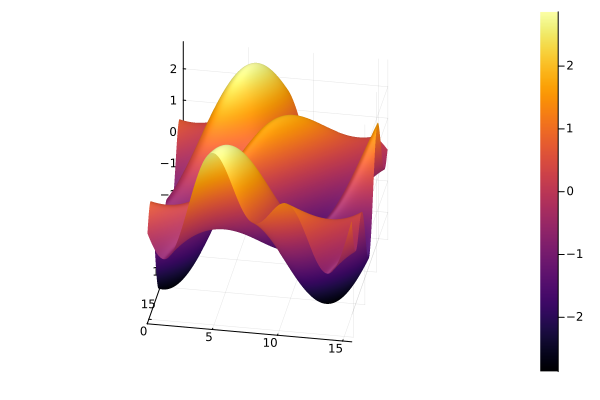

In [2]:
using Plots
f(x,y) = sin(x + y) + sin(0.5 * x) - cos(0.5 * y)# + x^2 + y^2;
x = 0:0.01:5pi
y = 0:0.01:5pi
plot(x, y, f; st=:surface, camera=(100,30))

Convexity is important because gradient descent is the method by which we find the bottom of these curves. Remembering that the bottom of a convex portion of the curve defines a local minima we can see that a method to find these points is incredibly valuable. Finding local minima (or maxima) is the primary goal of *optimisation*. You might remember from an elementary calculus class that these occur when then derivative of the function is 0; and that the second derivative test tells us if the point is a maximum (hump), or minimum (dip) and thus tells us about its curvature. This is very useful when we have a well defined gradient function which we can precisely solve the roots of: a very rare situation. Recall the definition of the derivitave of a function $f(\vec{x})$:

$$ \frac{\partial f(\vec{x})}{\partial \vec{x}} = \lim_{\vec{h}\rightarrow\vec{0}} \frac{f(\vec{x} + \vec{h}) - f(\vec{x})}{\vec{h}}$$

This definition makes it very easy to estimate the derivative of a function at a given point $\vec{x}$ by choosing an appropriately small perturbation $\vec{h}$. You may recall from Scientific Programming in Julia that it can be done with *abritrary* precision using automatic differentation. 

How does this help? The gradient of a function represents the rate of change of a function and tells us the direction of that change. For a single valued function this is given by the sign, for a vector valued function the direction of *greatest* change is given by the gradient vector often denoted $\nabla f$:

$$ \nabla f(x, y, ...) = \left(\frac{\partial f(x,y,...)}{\partial{x}}, \frac{\partial f(x,y,...)}{\partial{y}}, ...\right) $$

If we know the direction of greatest change in the function and we want to optimise it starting from a point $\vec{x}_0$ then a good strategy would be to move in that direction to maximise it, or in the oppositive direction (negative sign) to minimise it. The derivative is only valid close to, or in a *neighbourhood*, of the point $\vec{x_0}$ so the move will only be guarenteed to induce the change we want close by to where we calculate the derivative. Therefore, for an $0 <\alpha << 1$ the point:
 
$$ \vec{x}_1 = \vec{x}_0 - \alpha  \nabla f(\vec{x}_1), $$

is *guaranteed* to have the property $ f(\vec{x}_1) < f(\vec{x}_0) $. In other words, we have moved a step closer towards our goal of minimising (optimising) our function $f$. There is nothing stopping us from repeating this operation again and again getting an ever smaller value of $f$ so we define a sequence $x_t$ by:

$$ \vec{x}_t = \vec{x}_{t-1} - \alpha  \nabla f(\vec{x}_{t-1}), $$

which consequently defines the sequence $f(x_t)$ which is *monotonically decreasing*. Therefore, if the function has a local minimum somewhere near $x_0$ it has a *lower bound* and by the Montone Convergence Theorem our method is provably guarenteed to hit that bound (or get arbtrarily close) provided that we apply it enough times. If you haven't seen that theorem it is quite unecessary to understand the principle: if we know that we are above a number $A$, and we can't go below a another $B$, then by continually decreasing $A$ we will eventually hit $B$ i.e. all falling things hit the ground eventually.

While this has all been highly mathematical and quite abstract it is quite easy to code it into a function. Let's use the example function above because we can mathematically derive all of it's extrema. We will code a *numerical* differentation operator and apply it a number of times to see that it works:

In [3]:
d(f, v; h=0.001) = [f(v[1]+h, v[2]) - f(v[1], v[2]), f(v[1], v[2]+h) - f(v[1], v[2])] ./ h;
df(x,y) = [cos(x + y) + 0.5*cos(0.5 * x), cos(x + y) + 0.5 * sin(0.5 * y)]

# true_minima = 
vi = [10.0,11.0]
count = 1
alpha = 0.0001
while sqrt(d(f, vi)[1]^2 + d(f,vi)[2]^2) > 1e-14 && count < 10^9
    count+=1
    vi .= vi - alpha * d(f, vi)
end
println("The minimum of f is $(f(vi[1], vi[2])) at (x,y) = $(vi) with the true gradient at this point being ∇f(x,y) = $(df(vi[1], vi[2]))")

The minimum of f is -2.864195982403888 at (x,y) = [10.123829493576245, 13.265422147089335] with the true gradient at this point being ∇f(x,y) = [-0.000610026125276053, -0.0006100261432923915]


We can confirm by hand that indeed a solution for the minima is $f(\vec{x}_\text{min})=-3$ with $\vec{x}_\text{min} = (7\pi/2, 4\pi) \approx (10.99, 12.56)$. So we got pretty close, but not quite there! 

## 1.1 The nitty-gritty: implementation details

We now need to remove ourselves from the world of infinities and infinitesimials because we have neither infinite time to generate the sequence, nor memory to store an arbirarily small number. We must make some real *practical* choices. The most common choice to make is the step size $\alpha$ which is commonly referred to as the *learning rate*. This is known as a hyper-parameter and in all learning routines it is usually the one with the most impact. Set it too large and we will generate numerical instabilities and will not generate a solution. Set it too small and it will not move fast enough to reach the minima. Furthermore, the total step will depend on the learning rate *and* the curvature of the function at any given point.

To generate precision differentation we use *automatic differentation* routines. This allows us to not be concerned whether the gradient was computed correctly (outside of the typical numerical stability concerns of implementing a function computationally). 

Finally, we need to decide on a stopping condition. Since we typically do not know what the function extrema is we cannot code a true stopping condition. We therefore need to find a suitable proxy. The first, and most obvious, is to stop when the gradient is zero. This involves choosing a suitable bound and comparing it to the magnitude of the gradient at each step e.g. $|\nabla(f(\vec{x})| < \epsilon$. The choice of $\epsilon$ is user defined but it commonly chosen to be machine single or double precision i.e. $10^{-7}$ or $10^{-14}$. Some potential problems with this are:  

1) Incorrect choice of precision - the function might vary at much lower values than the specified $\epsilon$.

2) Periodic overshoots - a large step size will result in the particle overshooting the minimum and correcting on the next step going in circles.

3) Never reaching the minimia - a small step size might require a training routine longer than we have resources for.

The second obvious thing to is choose an upper acceptable time limit and run the routine until the time limit is reached. This has the advantage of knowing precisely the resource consumption *a priori* and compute can be appropriatley allocated. Since the gradient descent should always step in the right direction this will give close to the best possible value of the loss function for a given $\alpha$. It still requires tweaking with a given $\alpha$ and it can be very inefficient because we might arrive at an acceptable solution early in the routine and while running the whole routine will improve the solution it may not be *beneficial* to us: too many resources consumed for too little gain. In practice it is common to use both.

It is also possible to choose an acceptable *loss* and forget about finding a local minima entirely. The loss often represents some real world cost or performance target and stakeholders do not require a provably optimal solution; they require a *good-enough* solution. If we set the loss as the target we can use the descent routine to improve on exisiting solutions.


In [ ]:
# Code block with an ossicilatory, slow, and just right, learning rate. 

## 1.2 Flat and Jagged Surfaces: when things go wrong.



## 1.3 Netwons Method: the *best* step size
Gradient descent is dependent on both the learning rate and the functions curvature for any given step. When encountering jagged edges or flat surfaces this can introduce instabilities or significantly slow down the routine. It is desirable therefore to have an *adaptive* step size. We would like the routine to slow down when the curvature is high so that we don't make a giant leap and skip a large amount of information (and potentially violate the conditions of the gradient descent routine generating instability). Conversely, when the landscape is flat we would like to take a larger step and compensate for the small gradients.

Elementary calculus tells us the curvature is encoded in the *second* derivative of a function: we may recall performing the second derivative test to tell us if a function was curving up (-ve) or down (+ve) and thus determine the nature of a critical point. 

In [4]:
# code block for a function ____/\___. Too large step and we skip the jagged bit. Too small and we never arrive. Hessian gets us there just right.

## 1.4 Complexity: Slowing things down.

In the previous section we stated that using the Hessian matrix provides a provably optimal step size for the gradient descent routine. Presumably, this implies that gradient descent optimisation is in some sense *done*. Why can't we simply encode optimal routines in various languages and use API calls? 

The answer lies in the word *matrix*. The gradient descent routine is *linear* in the number of parameters while generating the Hessian is *quadratic*. In computational complexity theory we would denote these $O(n)$ and $O(n^2)$ respectively for $n$ parameters. What this means is that any increase in parameters will increase the time required to calculate the Hessian by that increases square. Since a parabola grows much faster than a line this increase in time is *very* noticeable when the amount of parameters is large. In deep learning we normally deal with *enormous* models and this makes computing the Hessian all but intractable. For this reason it is very rarely used.

In [ ]:
# Code block showing the complexity problem,

## 1.x Momentum: Speeding things up!



## 1.x Momentum Zoo: Really speeding things up!!

# 1.x Stochastic Gradient Descent

# 2.0 Regularisation

1. What is regularisation?
2. How can it be implemented in general
3. How *is it* implemented in Deep Learning
4. What are some general rules of thumb

# 3.0 Key Takeaways

A neural networks performance is measured by its objective or loss function. This is (usually) carefully designed to reflect some real-world performance target. The loss function can be optimised by any method but the most common is gradient descent which involves propogating losses back through the network: a technique known as *back-propagation*. Gradient descent is best used with an adapative step size but the mathematically ideal method for choosing this step is too expensive to compute. To compensate for this costs momemtum routines have been developed which have similar properties but are cheap. There is currently debate about whether these routines are better than stochastic gradient descent in a global sense. Regularisation is used to improve the stability of training a neural network.